# Assignment 4
Training a simple neural net for relation classification.

# New section

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.9 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 86 kB 5.4 MB/s 
     |████████████████████████████████| 596 kB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
# framework
import torch
import torch.nn as nn
# math
import math
import numpy as np
import pandas as pd
# stats 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
# debug
import warnings
warnings.filterwarnings('ignore')
# transformers
from transformers import AutoConfig, AutoModel
from transformers import BertTokenizer
from transformers import BertForSequenceClassification

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# print(device)

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.

The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf). The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)


In this work we will use the hugingface framework for transformers training and inference. We recomand reading the documentation in https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification *before* you start coding. 


**Task 1:** Write a funtion *read_data* for reading the data from a single file (either train or test). This function recieves a filepath and returns a list of sentence. Every sentence is encoded as a touple, where the first element is the sentence string and the second the label (also represented as a sting). 

In [ ]:
!git clone https://github.com/kfirbar/nlp-course

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10).to(device)

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), done.


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
def read_data(filepath):
    data = []
    with open(filepath) as file:
        input_text = file.readlines()

    for i in range(0, len(input_text), 4):
      data.append((input_text[i].split('\t')[1][1:-2], input_text[i+1][:-1]))

    return data


train = read_data('/content/nlp-course/TRAIN_FILE.TXT')
test = read_data('/content/nlp-course/TEST_FILE_FULL.TXT')

Pytorch require the labels to be integers. Create a mapper (dictionary) from the string labels to integers (starting zero). 

In [ ]:
def create_label_mapper(data):
  labels = set([label[1].replace('(e1,e2)', '').replace('(e2,e1)', '') for label in data])
  labels_mapper = {v: i for i, v in enumerate(labels)}
  return labels_mapper            

In [ ]:

labels_mapper = create_label_mapper(train)         
labels_mapper   

{'Cause-Effect': 5,
 'Component-Whole': 1,
 'Content-Container': 4,
 'Entity-Destination': 7,
 'Entity-Origin': 9,
 'Instrument-Agency': 6,
 'Member-Collection': 2,
 'Message-Topic': 3,
 'Other': 8,
 'Product-Producer': 0}

**Task 2:** Write a function *prepare_data* that takes one of the [train, test] datasets and convert each pair of (words,labels) to a pair of indexes. The function also aggregate the samples into batches. BERT Uses pretrained tokanization and embedding. you can access the tokanization and indexing using the BertTokenizer class.

In [ ]:
# pre-requisite
from transformers import BertTokenizer

def prepare_data(data, tokenizer, batch_size=8):
  data_sequences = []
  labels_mapper = create_label_mapper(data)
  n = int(np.ceil(len(data) / batch_size))
  for batch in range(n):
      sentences_l, labels_l = [], []
      batch_start =  batch * batch_size
      batch_end = min(len(data), batch_start + batch_size)
      for sentence, label in data[batch_start:batch_end]:
          label = label.replace('(e1,e2)', '').replace('(e2,e1)', '')
          sentence = sentence.replace('<e1>', '').replace('<e2>', '').replace('</e1>', '').replace('</e2>', '')
          label_i = labels_mapper[label]
          sentences_l.append(sentence)
          labels_l.append(label_i)

      batch_token = tokenizer(sentences_l, padding=True, truncation=True, return_tensors="pt")                   
      data_sequences.append((batch_token['input_ids'], batch_token['attention_mask'], labels_l))

  return data_sequences


In [ ]:
train_sequences = prepare_data(train, tokenizer)
test_sequences = prepare_data(test, tokenizer)

**Task 3:** In this part we classify the sentences using the BertForSequenceClassification model. To save resources, we initialize the optimizer with the final layer of the model. You are also allowed to change the learning rate.

In [ ]:
def get_parameters(params):
  param_list = []
  for sentence, param in params:  
    param.requires_grad = 'classifier' in sentence
    param_list.append(param)

  return param_list

**Task 4:** Write a training loop, which takes a BertForSequenceClassification model and number of epochs to train on. The loss is always CrossEntropyLoss and the optimizer is always Adam. You are allowed to split the train to train and dev sets.

In [ ]:
from transformers import BertForSequenceClassification

def train_loop(model, n_epochs, train_data, dev_data):
  # Loss function
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.0001)
  model.train()
 
  for e in range(1, n_epochs + 1):
    # TODO - your code goes here...
    for i, mask, label in train_data:
      model.zero_grad()
      m_logits = model(i.to(device), mask.to(device))['logits']
      loss_entropy = criterion(m_logits, torch.tensor(label).to(device))
      loss_entropy.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      
  return model

**Task 5:** write an evaluation loop on a trained model, using the dev and test datasets. This function print the true positive rate (TPR), also known as Recall and the opposite to false positive rate (FPR), also known as precision, of each label seperately (10 labels in total), and for all labels together. The caption argument for the function should be served for printing, so that when you print include it as a prefix.

In [ ]:
def evaluate(model, test_data):
  # TODO - your code goes here 
  model.eval()
  predict_label_l ,true_label_l = torch.tensor([]).to(device), torch.tensor([]).to(device)
  df = pd.DataFrame(columns=['TRP', 'FPR'])
  sum_FPR = 0
  sum_TPR = 0

  for i, mask, label in test_data:
    label = torch.tensor(label).to(device)
    with torch.no_grad():
      logits = model(i.to(device), mask.to(device))['logits']
      predict_label_l = torch.cat((predict_label_l, torch.argmax(logits, axis=1)))
      true_label_l = torch.cat((true_label_l, label))

  predict_label_l = predict_label_l.tolist()
  true_label_l = true_label_l.tolist()
  flipped_label_l = {val:key for key, val in labels_mapper.items()}
  ans = dict.fromkeys(labels_mapper.keys())

  for key in ans.keys(): 
    ans[key] = {"TP": 0, "FP": 0, "FN": 0}

  true_label_l = list(map(lambda n: flipped_label_l[n], true_label_l))
  predict_label_l = list(map(lambda n: flipped_label_l[n], predict_label_l))
  zip_labels = zip(predict_label_l, true_label_l)
  for pred_label, true_label in zip_labels:
      if pred_label == true_label:
          ans[true_label]["TP"] += 1
      else:
          ans[pred_label]["FP"] += 1
          ans[true_label]["FN"] += 1

  for i in ans.keys():
      fp = ans[i]["FP"]
      fn = ans[i]["FN"]
      tp = ans[i]["TP"]
      tpr = tp / (tp + fn)
      fpr = tp / (tp + fp)
      sum_FPR += fpr
      sum_TPR += tpr
      df.loc[i] = [np.round(fpr, 3), np.round(tpr, 3)]

  m = len(ans) - 1
  sum_FPR /= m
  sum_TPR /= m
  df.loc["SUM"] = [np.round(sum_FPR,3), np.round(sum_TPR, 3)]
  display(df)

In [ ]:
model = train_loop(model, 80, train_sequences, None)

In [ ]:
evaluate(model.to(device), test_sequences)

,TRP,FPR
Product-Producer,0.352,0.216
Component-Whole,0.614,0.337
Member-Collection,0.000,0.000
Message-Topic,0.053,0.004
Content-Container,0.606,0.521
Cause-Effect,0.464,0.774
Instrument-Agency,0.350,0.135
Entity-Destination,0.786,0.038
Other,0.209,0.670
Entity-Origin,0.493,0.256


**Task 6:** In this part we'll improve the model accuracy by using a method called "entity markers - Entity start". The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. instead of using the CLS toekn for clasification, we will use the concatination of the embedding of [e1] and [e2] as shown in the image below. The complete method is described in details in the following paper - https://arxiv.org/pdf/1906.03158.pdf (specifically in Section 3.2). To use this method we'll need to create a new data load and a new model.

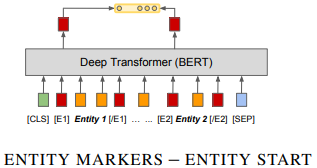

The new methods require the usage of special tokens. The following code will add the required tokens.

In [ ]:
tokenizer.add_tokens(['<e1>', '</e1>', '<e2>', '</e2>'])
labels_dict = create_label_mapper(train)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=8):
    
    data_sequences = []
    number_of_batches = math.ceil(len(data) / batch_size)

    e1_start, e2_start = tokenizer.added_tokens_encoder['<e1>'], tokenizer.added_tokens_encoder['<e2>']
    input_ids, attention_masks, labels, e1_e2_idxs = [], [], [], []

    for batch in range(number_of_batches):
        batch_sentences = []
        batch_labels = []

        batch_start_idx = batch * batch_size
        batch_end_idx = batch_start_idx + batch_size

        if batch_end_idx > len(data):
            batch_end_idx = len(data)

        for i in range(batch_start_idx, batch_end_idx):
            current_sen_label = data[i]
            current_sentence = current_sen_label[0]

            current_label = current_sen_label[1]
            current_label = current_label.replace('(e1,e2)', '').replace('(e2,e1)', '')
            
            current_label_idx = labels_dict[current_label]


            batch_sentences.append(current_sentence)
            batch_labels.append(current_label_idx)


        batch_tokend = tokenizer(batch_sentences, max_length = 256, 
                                 padding='max_length', return_tensors="pt", 
                                 add_special_tokens=True)            

        b_input_ids, b_attn_mask = batch_tokend['input_ids'], batch_tokend['attention_mask']            

        batch_e1 = (b_input_ids ==e1_start).nonzero()[:,1] 
        batch_e2 = (b_input_ids ==e2_start).nonzero()[:,1] 

        e1_e2_idxs = (batch_e1, batch_e2)

        current_sample = ((b_input_ids, b_attn_mask), batch_labels, e1_e2_idxs)

        
        data_sequences.append(current_sample)
        
    return data_sequences


train_sequences_MTB = prepare_data_MTB(train, tokenizer)
test_sequences_MTB = prepare_data_MTB(test, tokenizer)


Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
    def __init__(self, base_model_name):
        super(MTB, self).__init__()
        config = AutoConfig.from_pretrained(base_model_name)
        config.num_labels = 10
        self.bert = AutoModel.from_pretrained(base_model_name, config=config)
        self.bert.resize_token_embeddings(len(tokenizer))
        self.num_labels = config.num_labels
        self.hidden_size = config.hidden_size
        self.classifier = nn.Linear(self.hidden_size * 2, self.num_labels)

    def forward(self, input, index):
        (input_ids, attention_mask) = input
        e1 = torch.tensor(index[0])
        e2 = torch.tensor(index[1])
        e1 =  e1.unsqueeze(-1)
        e2 =  e2.unsqueeze(-1)
        outputs = self.bert(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states_last = outputs.hidden_states[12].to(device)
        e1_idxes = (e1.repeat(1,self.hidden_size).to(device)).unsqueeze(1)
        e2_idxes = (e2.repeat(1,self.hidden_size).to(device)).unsqueeze(1)
        e1_hidden_states = torch.gather(hidden_states_last, 1, e1_idxes)
        e1_hidden_states = torch.squeeze(e1_hidden_states, dim=1)
        e2_hidden_states = torch.gather(hidden_states_last, 1, e2_idxes)
        e2_hidden_states = torch.squeeze(e2_hidden_states,dim=1)
        e1_e2_hidden_states = torch.cat((e1_hidden_states, e2_hidden_states), dim=1)
        output = self.classifier(e1_e2_hidden_states)
    
        return output

In [ ]:
def train_loop_MTB(model, n_epochs, train_data, dev_data):
  # Loss function
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(get_parameters(model.named_parameters()), lr=0.0001)
  model.train()
 
  for e in range(1, n_epochs + 1):
    # TODO - your code goes here...
    for (i, mask) , labels, e1e2 in train_data:
      model.zero_grad()
      m_logits = model((i.to(device), mask.to(device)), e1e2).to(device)
      loss_entropy = criterion(m_logits, torch.tensor(labels).to(device))
      loss_entropy.backward()
      optimizer.step()
    
  return model

In [ ]:
def evaluate_MTB(model, test_data):
  # TODO - your code goes here
  df = pd.DataFrame(columns=['TRP', 'FPR'])
  sum_FPR = 0
  sum_TPR = 0
  model.eval()
  predict_label_l ,true_label_l = torch.tensor([]).to(device), torch.tensor([]).to(device)
  

  for (i, mask), label, e1_e2 in test_data:
    label = torch.tensor(label).to(device)
    with torch.no_grad():
      logits = model((i.to(device), mask.to(device)), e1_e2)
      logits = torch.log_softmax(logits, dim=1)
      predict_label_l = torch.cat((predict_label_l, torch.argmax(logits, axis=1)))
      true_label_l = torch.cat((true_label_l, label))

  predict_label_l = predict_label_l.tolist()
  true_label_l = true_label_l.tolist()
  flipped_labels = {val:key for key, val in labels_dict.items()}
  ans = dict.fromkeys(labels_dict.keys())

  for key in ans.keys(): 
    ans[key] = {"TP": 0, "FP": 0, "FN": 0}

### show the results ###
  predict_label_l = list(map(lambda n: flipped_labels[n], predict_label_l))
  true_label_l = list(map(lambda n: flipped_labels[n], true_label_l))
  zip_labels = zip(predict_label_l, true_label_l)

  for pred_label, true_label in zip_labels:

      if pred_label == true_label:
          ans[true_label]["TP"] += 1
      else:
          ans[pred_label]["FP"] += 1
          ans[true_label]["FN"] += 1

  for i in ans.keys():
      fp = ans[i]["FP"]
      fn = ans[i]["FN"]
      tp = ans[i]["TP"]
      tpr = tp / (tp + fn)
      fpr = tp / (tp + fp)
      sum_FPR += fpr
      sum_TPR += tpr
      df.loc[i] = [np.round(fpr, 3), np.round(tpr, 3)]

  m = len(ans) - 1
  sum_FPR /= m
  sum_TPR /= m
  df.loc["SUM"] = [np.round(sum_FPR,3), np.round(sum_TPR, 3)]

  display(df)

Use the new dataloader and model to train and evaluate the new model as in task 4 and 5

In [ ]:
model_MTB = MTB('bert-base-uncased').to(device)
model_MTB = train_loop_MTB(model_MTB, 5, train_sequences_MTB, dev_data=None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_MTB = MTB('bert-base-uncased').to(device)
model_MTB = train_loop_MTB(model_MTB, 15, train_sequences_MTB, dev_data=None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_MTB = MTB('bert-base-uncased').to(device)
model_MTB = train_loop_MTB(model_MTB, 35, train_sequences_MTB, dev_data=None)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
evaluate_MTB(model_MTB, test_sequences_MTB)

,TRP,FPR
Product-Producer,0.697,0.736
Component-Whole,0.835,0.712
Member-Collection,0.802,0.781
Message-Topic,0.824,0.755
Content-Container,0.804,0.833
Cause-Effect,0.850,0.918
Instrument-Agency,0.760,0.609
Entity-Destination,0.859,0.750
Other,0.421,0.548
Entity-Origin,0.797,0.671


**Good luck!**